In [193]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from torchvision import datasets
import os
from itertools import chain, product
from development import data_handler

# Metrics calculation

In [194]:
DATA_PATH = "../data/survey_results/data_tu-helpfulness-of-xai_2022-06-29_10-48.xlsx"
DATA_PREPARED_PATH = f"{DATA_PATH.rsplit('.',1)[0]}_PREPARED.{DATA_PATH.rsplit('.',1)[1]}"
df = pd.read_excel(DATA_PATH)
df_merged = pd.read_excel(DATA_PREPARED_PATH)

In [195]:
df_quest_meta = pd.read_excel("../data/survey_results/question_meta_data.xlsx")

## Metrics on all images (fixed + random)

### Overall ability to guess model is correct if actually correct

In [196]:
# explicit calculation of ratios as verification for grouped calulations further below
num_guessed_correct_if_correct = df_merged[(df_merged["is_pred_correct"] == True) & (df_merged["response"] == True)].shape[0]
num_correct_overall = df_merged[df_merged["is_pred_correct"] == True].shape[0]

In [197]:
num_guessed_correct_if_correct / num_correct_overall

0.6268382352941176

### Overall ability to guess model is wrong if actually wrong

In [198]:
num_guessed_wrong_if_wrong = df_merged[(df_merged["is_pred_correct"] == False) & (df_merged["response"] == False)].shape[0]
num_wrong_overall = df_merged[df_merged["is_pred_correct"] == False].shape[0]

In [199]:
num_guessed_wrong_if_wrong / num_wrong_overall

0.5471813725490197

### Ability for each XAI-method to guess model is correct/wrong if actually correct/wrong & general accuray

In [200]:
def accuracy_per_groupby(df_merged, group_by=["method"], drop_na=False):
    # ACCURACY = (TP + TN) / (TP + TN + FP + FN)
    schema_cols = [df_merged[column].drop_duplicates() for column in group_by + ["is_pred_correct", "response"]]
    schema_col_names = [ser.name for ser in schema_cols]
    df_schema = pd.DataFrame(list(product(*schema_cols))).groupby(list(np.arange(len(schema_cols)))).count()
    df_schema = df_schema.reset_index()
    df_schema.columns=schema_col_names
    
    ser_denominators = df_merged.groupby(by=group_by, dropna=drop_na)["response"].count().sort_index()
    df_numerators = df_merged.groupby(by=group_by + ["is_pred_correct", "response"], dropna=drop_na)["response"].count().to_frame("count").reset_index()
    df_numerators = df_schema.merge(right=df_numerators, on=schema_col_names, how="left").fillna(0)
    ser_numerators = df_numerators[df_numerators["is_pred_correct"] == df_numerators["response"]].groupby(group_by, dropna=drop_na)["count"].sum().sort_index()
    df_accuracies = (ser_numerators / ser_denominators).to_frame("accuracy")
    return df_accuracies

In [201]:
df_accuracy = accuracy_per_groupby(df_merged)

<AxesSubplot:xlabel='method'>

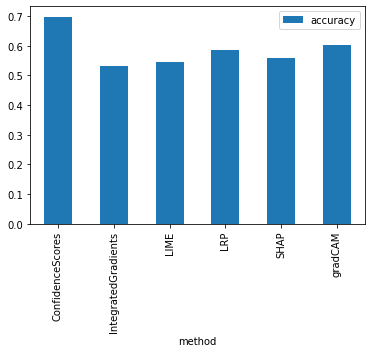

In [202]:
df_accuracy.plot.bar()

In [203]:
df_accuracy

,accuracy
method,
ConfidenceScores,0.698529
IntegratedGradients,0.533088
LIME,0.545956
LRP,0.584559
SHAP,0.558824
gradCAM,0.601103


In [204]:
# accuracy overall
df_accuracy.mean()

accuracy    0.58701
dtype: float64

In [205]:
def create_individual_ratios(df_merged):
    # CORRECT = TP / TP + FN; WRONG = TN / TN + FP
    df_ratios_per_method = df_merged.groupby(by=["method", "is_pred_correct"])["response"].value_counts(normalize=True).to_frame("ratio").reset_index()
    df_ratios_per_method = df_ratios_per_method[df_ratios_per_method["is_pred_correct"] == df_ratios_per_method["response"]].reset_index(drop=True)
    # append overall averages
    df_ratios_per_method.loc[len(df_ratios_per_method)] = ["Overall", False, False, df_ratios_per_method[df_ratios_per_method["is_pred_correct"] == False]["ratio"].mean()]
    df_ratios_per_method.loc[len(df_ratios_per_method)] = ["Overall", True, True, df_ratios_per_method[df_ratios_per_method["is_pred_correct"] == True]["ratio"].mean()]
    return df_ratios_per_method

In [206]:
df_ratios_per_method = create_individual_ratios(df_merged)

In [207]:
df_ratios_per_method

,method,is_pred_correct,response,ratio
0,ConfidenceScores,False,False,0.647059
1,ConfidenceScores,True,True,0.750000
2,IntegratedGradients,False,False,0.511029
3,IntegratedGradients,True,True,0.555147
4,LIME,False,False,0.503676
5,LIME,True,True,0.588235
6,LRP,False,False,0.426471
7,LRP,True,True,0.742647
8,SHAP,False,False,0.775735
9,SHAP,True,True,0.341912


In [208]:
def plot_ratios(df_ratios_per_method, title_addition=""):        
    fig, ax = plt.subplots(figsize=(14, 5))
    ax.scatter(x=df_ratios_per_method["method"].drop_duplicates(), y=df_ratios_per_method[df_ratios_per_method["is_pred_correct"] == True]["ratio"], c="orange", label="Guessed Correct when Model Correct (Sensitivity)")
    ax.scatter(x=df_ratios_per_method["method"].drop_duplicates(), y=df_ratios_per_method[df_ratios_per_method["is_pred_correct"] == False]["ratio"], c="purple", label="Guessed Wrong when Model Wrong (Specitivity)")
    ax.plot(df_ratios_per_method["method"], [0.5] * len(df_ratios_per_method), color="red", linestyle='dashed', label="baseline")
    ax.set_title(f"{title_addition} Performance Ratios for chosen XAI-Methods ({len(df)} participants considered)", size=15)
    ax.set_xlabel("XAI-Method", size=13)
    ax.set_ylabel("Ratio", size=13)
    for i, txt in enumerate(df_ratios_per_method["ratio"].round(2)):
        ax.annotate(txt, (list(df_ratios_per_method["method"])[i], list(df_ratios_per_method["ratio"])[i]))
    ax.legend(loc="best", edgecolor="black")

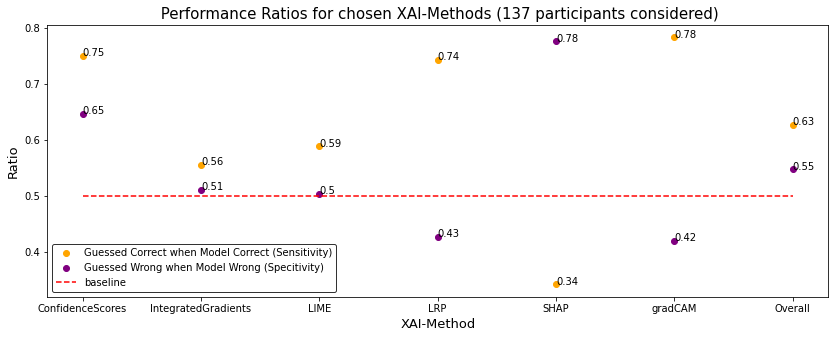

In [209]:
plot_ratios(df_ratios_per_method)

## Metrics only on fixed images

In [210]:
fixed_img_idxs = df_quest_meta["img_idx"].value_counts()[df_quest_meta["img_idx"].value_counts() == 12].index
df_quest_meta_fixed = df_quest_meta[df_quest_meta["img_idx"].isin(fixed_img_idxs)]

In [211]:
df_merged_fixed = df_merged[df_merged["img_idx"].isin(fixed_img_idxs)]

In [212]:
df_ratios_per_method_fixed = create_individual_ratios(df_merged_fixed)

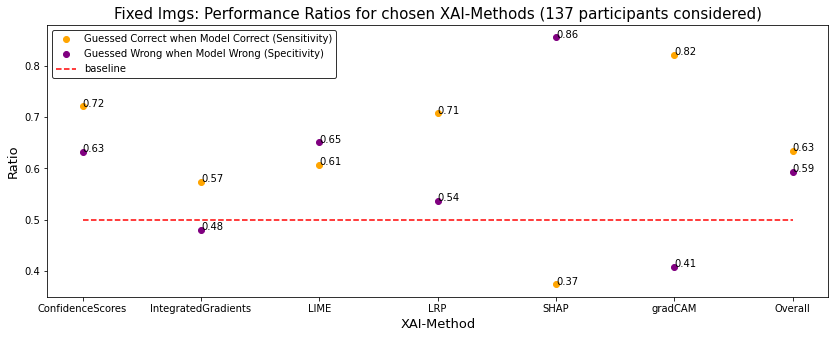

In [213]:
plot_ratios(df_ratios_per_method_fixed, "Fixed Imgs:")

## Boxplots over individual participants metrics

In [214]:
def plot_metric_boxplot(df_metrics, by, column, xlabel="XAI-Method", ylabel="Accuracy", title=""):
    ax = df_metrics.boxplot(by=by, column=column, figsize=(14, 5))
    fig = plt.gcf()
    fig.suptitle(None)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    #xai = df_metrics[]
    #ax.plot(["ConfidenceScores", "gradCAM"], [0.5, 0.5], c="red", linestyle="dashed")
    plt.show()
    plt.close()

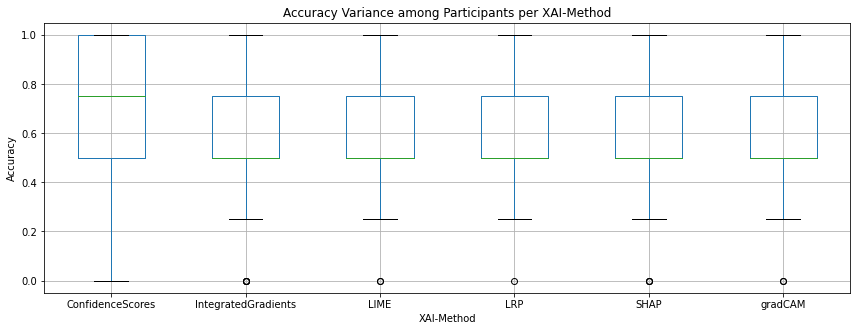

In [215]:
plot_metric_boxplot(accuracy_per_groupby(df_merged, ["method", "case"]).reset_index(), ["method"], "accuracy", title="Accuracy Variance among Participants per XAI-Method")

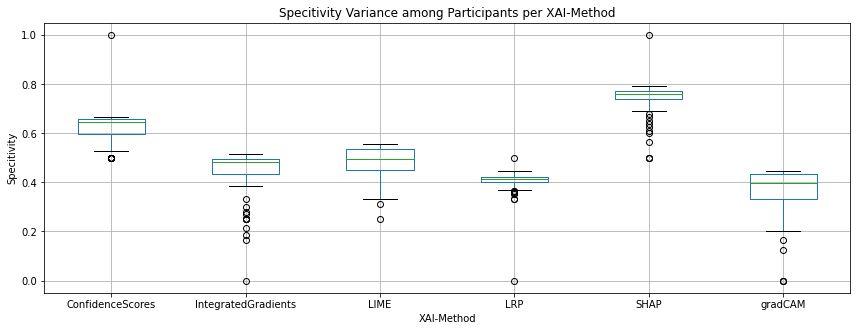

In [216]:
df_ratios_convergence_false = df_ratios_convergence[df_ratios_convergence.index.get_level_values(1) == False].reset_index()
plot_metric_boxplot(df_ratios_convergence_false, ["method"], "ratio", ylabel="Specitivity", title="Specitivity Variance among Participants per XAI-Method")

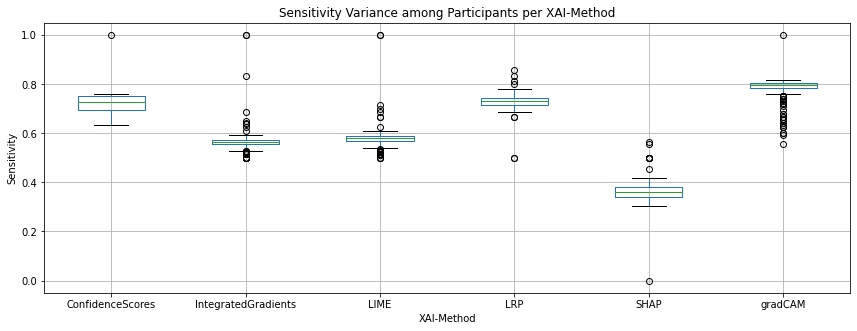

In [217]:
df_ratios_convergence_true = df_ratios_convergence[df_ratios_convergence.index.get_level_values(1) == True]
plot_metric_boxplot(df_ratios_convergence_true, ["method"], "ratio", ylabel="Sensitivity", title="Sensitivity Variance among Participants per XAI-Method")

## Convergence of metrics

In [218]:
def create_individual_ratios_per_participant(df_merged):
    # df_schema needed to get all TP,TN,FP,FN i.e. where value_counts() would evaluate nothing because not existent (0)
    df_schema = pd.DataFrame(list(product(df_merged["case"].drop_duplicates(), df_merged["method"].drop_duplicates(), df_merged["is_pred_correct"].drop_duplicates(), df_merged["response"].drop_duplicates()))).groupby([0, 1, 2, 3]).count()
    df_schema = df_schema.reset_index()
    df_schema.columns=['case', 'method', 'is_pred_correct', 'response']
    df_ratios_per_method_and_part = df_merged.groupby(by=["case", "method", "is_pred_correct"])["response"].value_counts(normalize=True).to_frame("ratio").reset_index()
    df_ratios_per_method_and_part = df_schema.merge(right=df_ratios_per_method_and_part, on=["case", "method", "is_pred_correct", "response"], how="left")
    df_ratios_per_method_and_part = df_ratios_per_method_and_part.fillna(0)
    # only filter for TP and TP (just for now, might get modified)
    df_ratios_per_method_and_part = df_ratios_per_method_and_part[df_ratios_per_method_and_part["is_pred_correct"] == df_ratios_per_method_and_part["response"]].reset_index(drop=True)
    return df_ratios_per_method_and_part.groupby(by=["method", "is_pred_correct"]).expanding().mean()#.reset_index(level=2, drop=True)


In [219]:
df_ratios_convergence = create_individual_ratios_per_participant(df_merged)
df_ratios_convergence

case  response     ratio
method           is_pred_correct                                      
ConfidenceScores False           0      579.000000       0.0  1.000000
                                 12     580.000000       0.0  0.500000
                                 24     582.333333       0.0  0.500000
                                 36     584.000000       0.0  0.500000
                                 48     588.200000       0.0  0.600000
...                                            ...       ...       ...
gradCAM          True            1583  1123.303030       1.0  0.791667
                                 1595  1127.293233       1.0  0.789474
                                 1607  1131.238806       1.0  0.783582
                                 1619  1135.140741       1.0  0.785185
                                 1631  1139.000000       1.0  0.783088

[1632 rows x 3 columns]

In [220]:
def plot_ratio_convergence(df_ratios_convergence):
    fig, ax = plt.subplots(figsize=(14, 5))
    ax.set_xlabel("Number Participants", size=13)
    ax.set_ylabel("Ratio", size=13)
    ax.set_title("Convergence of Ratios as Ratios are calculated over increasing Numbers of Participants", size=15)
    for method in df_ratios_convergence.index.get_level_values(0).drop_duplicates():
        for outcome in df_ratios_convergence.index.get_level_values(1).drop_duplicates():
            ax.plot(list(range(len(df_ratios_convergence.loc[method, outcome]))), df_ratios_convergence.loc[method, outcome]["ratio"], label=f"{method}, {outcome}")
            print(df_ratios_convergence.loc[method, outcome]["ratio"].iloc[-1])
    ax.legend(loc="lower center", edgecolor="black")

In [221]:
def plot_accuracy_convergence(df_accuracy_conv):
    fig, ax = plt.subplots(figsize=(14, 5))
    ax.set_xlabel("Number Participants", size=13)
    ax.set_ylabel("Accuracy", size=13)
    ax.set_title("Convergence of Accuracies as Number of Participants increase", size=15)
    for method in df_accuracy_conv.index.get_level_values(0).drop_duplicates():
        ax.plot(list(range(len(df_accuracy_conv.loc[method]))), df_accuracy_conv.loc[method]["accuracy"], label=f"{method}")
            # print(df_ratios_convergence.loc[method, outcome]["ratio"].iloc[-1])
    ax.legend(loc="lower center", edgecolor="black")
        

In [222]:
df_accuracy_conv = accuracy_per_groupby(df_merged, ["method", "case"]).groupby(level=0).expanding().mean().reset_index(level=[1, 2], drop=True)

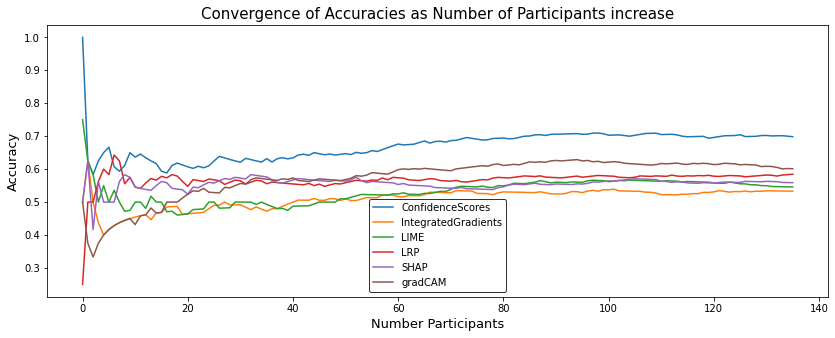

In [223]:
plot_accuracy_convergence(df_accuracy_conv)

## Metrics per questionnaire form (detect outlier questionnaires)

In [224]:
df_accuracy_qustnr_method = accuracy_per_groupby(df_merged, group_by=["QUESTNNR", "method"])

TypeError: 'bool' object is not subscriptable

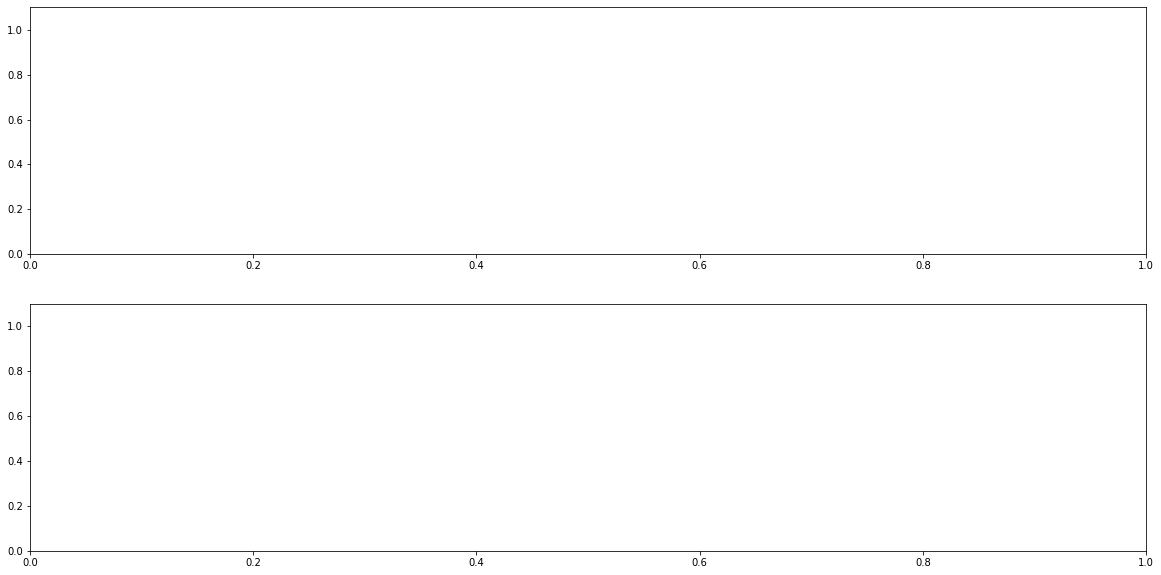

In [225]:
plot_2_indexes_1_plot(df_accuracy_qustnr_method, "XAI Method", "Accuracy", "Comparing Accuracy Scores for different Questionnaire Forms")

In [ ]:
def create_individual_ratios_per_questionnaire(df_merged):
    df_ratios_per_method = df_merged.groupby(by=["QUESTNNR", "method", "is_pred_correct"])["response"].value_counts(normalize=True).to_frame("ratio").reset_index()
    df_ratios_per_method = df_ratios_per_method[df_ratios_per_method["is_pred_correct"] == df_ratios_per_method["response"]].reset_index(drop=True)
    # append overall averages
    #df_ratios_per_method.loc[len(df_ratios_per_method)] = ["Overall", False, False, df_ratios_per_method[df_ratios_per_method["is_pred_correct"] == False]["ratio"].mean()]
    #df_ratios_per_method.loc[len(df_ratios_per_method)] = ["Overall", True, True, df_ratios_per_method[df_ratios_per_method["is_pred_correct"] == True]["ratio"].mean()]
    return df_ratios_per_method

In [ ]:
df_ratios_qustn = create_individual_ratios_per_questionnaire(df_merged)

In [ ]:
def plot_boxplot_over_qnrs_per_method(df_ratios_qustn):
    fig, ax = plt.subplots(6, 1, figsize=(20, 6*5))
    for meth_idx, meth in enumerate(df_ratios_qustn.index.levels[0]):
        for out_idx, out in enumerate(df_ratios_qustn.index.levels[1]):
            ax[meth_idx].scatter(df_ratios_qustn.loc[meth, out]["QUESTNNR"], df_ratios_qustn.loc[meth, out]["ratio"], label=out)
            ax[meth_idx].set_title(meth)
            ax[meth_idx].legend()

In [ ]:
ax = df_ratios_qustn.boxplot(by=["method", "is_pred_correct"], column="ratio", figsize=(20, 5))
ax.set_ylabel("Test")

In [ ]:
# each boxplot was genereated on the basis of 12 ratio values origin from the 12 questionnaires.
# interpretation: per method an output the ratios vary quite a lot over the 12 questionnaires.
# for a more drilled down view on each single ratio per method and questionnaire form see comprehensive view below

In [ ]:
def plot_ratios_per_questionnaire(df_ratios_qustn):
    df_ratios_qustn = df_ratios_qustn.set_index(["method", "is_pred_correct"])
    fig, ax = plt.subplots(6, 1, figsize=(20, 6*5))
    for meth_idx, meth in enumerate(df_ratios_qustn.index.levels[0]):
        for out_idx, out in enumerate(df_ratios_qustn.index.levels[1]):
            ax[meth_idx].scatter(df_ratios_qustn.loc[meth, out]["QUESTNNR"], df_ratios_qustn.loc[meth, out]["ratio"], label=out)
            ax[meth_idx].set_title(meth)
            ax[meth_idx].legend()

In [ ]:
plot_ratios_per_questionnaire(df_ratios_qustn)

## Accuracy for different education levels

In [ ]:
df_accuracy_edu_method = accuracy_per_groupby(df_merged, group_by=["Education", "method"])

In [ ]:
def plot_2_indexes_1_plot(df_double_index, xlabel, ylabel, title, drop_na=True, drop_duplicates=True, mean_idx_order=None):
    fig, ax = plt.subplots(2, 1, figsize=(20, 10))
    plt.setp(ax, ylim=(0, 1.1))
    if drop_duplicates:
        ser_level_1_count = df_merged.drop_duplicates("case").groupby(df_double_index.index.levels[0].name, dropna=drop_na[df_merged.columns[0]]).count()
        
        
    

In [ ]:
def plot_2_indexes_1_plot(df_double_index, xlabel, ylabel, title, drop_na=True, drop_duplicates=True, mean_idx_order=None):
    fig, ax = plt.subplots(2, 1, figsize=(20, 10))
    plt.setp(ax, ylim=(0, 1.1))
    if drop_duplicates:
        ser_level_1_count = df_merged.drop_duplicates("case").groupby(df_double_index.index.levels[0].name, dropna=drop_na)[df_merged.columns[0]].count()
    else:
        ser_level_1_count = df_merged.groupby(df_double_index.index.levels[0].name, dropna=drop_na)[df_merged.columns[0]].count()
                                                                                                                            
    ser_acc_mean = df_double_index.mean(level=0)[df_double_index.columns[0]]
    # reorder bars in barplot as specified
    if mean_idx_order:
        ser_acc_mean = ser_acc_mean.reindex(mean_idx_order)
                                                                                                                         
    pps = ax[0].bar(ser_acc_mean.index, ser_acc_mean)
    for p in pps:
        height = p.get_height()
        ax[0].text(x=p.get_x() + p.get_width() / 2, y=height+.05,
          s=round(height, 2),
          ha='center', size=12)
    ax[0].set_xlabel(ser_acc_mean.index.name, size=15)
    ax[0].set_ylabel("Accuracy", size=15)
    ax[0].set_title(f"Mean Accuracy over all XAI-Methods per {ser_acc_mean.index.name}", size=20)
    
    for idx_level_1 in df_double_index.index.levels[0]:
        ax[1].plot(df_double_index.loc[idx_level_1].index, list(df_double_index.loc[idx_level_1][df_double_index.columns[0]]), label=f"{idx_level_1} ({ser_level_1_count[idx_level_1]})")
        ax[1].scatter(df_double_index.loc[idx_level_1].index, list(df_double_index.loc[idx_level_1][df_double_index.columns[0]]))
    ax[1].legend()
    ax[1].set_xlabel(xlabel, size=15)
    ax[1].set_ylabel(ylabel, size=15)
    ax[1].set_title(title, size=20)
    plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.3, wspace=0.4)
    plt.show()
    plt.close()

In [ ]:
plot_2_indexes_1_plot(df_accuracy_edu_method, "XAI Method", "Accuracy", "Accuracy Scores for different XAI Methods for different Education Levels")

## Accuracy for different ML-Experience

In [ ]:
df_accuracy_mlex_method = accuracy_per_groupby(df_merged, group_by=["ML Experience", "method"])

In [ ]:
plot_2_indexes_1_plot(df_accuracy_mlex_method, "XAI Method", "Accuracy", "Comparing Accuracy Scores for different ML Experience Length", mean_idx_order=["Not at all", "Under 1 year", "Between 1 and 3 years", "Between 3 and 5 years", "More than 5 years"])

## Accuracy for different perceived XAI-Experience Usefulness

In [ ]:
df_accuracy_xaiusef_method = accuracy_per_groupby(df_merged, group_by=["ML Experience Usefulness", "method"])

In [ ]:
plot_2_indexes_1_plot(df_accuracy_xaiusef_method, "XAI Method", "Accuracy", "Comparing Accuracy Scores for different perceived ML-Experience Usefulness")

## Accuracy for different models

In [ ]:
df_accuracy_model_method = accuracy_per_groupby(df_merged, group_by=["model", "method"])

In [ ]:
plot_2_indexes_1_plot(df_accuracy_model_method, "XAI Method", "Accuracy", "Comparing Accuracy Scores for different Models", drop_duplicates=False)

## Accuracy for colorblindness yes/no

In [ ]:
df_accuracy_colorb_method = accuracy_per_groupby(df_merged, group_by=["Color Blindness", "method"])

In [ ]:
plot_2_indexes_1_plot(df_accuracy_colorb_method, "XAI Method", "Accuracy", "Comparing Accuracy Scores for different Color Blindness", drop_duplicates=True)

## Accuracy for visual impairment

In [ ]:
df_accuracy_visimp_method = accuracy_per_groupby(df_merged, group_by=["Visual Impairment Affect", "method"], drop_na=True)

In [ ]:
plot_2_indexes_1_plot(df_accuracy_visimp_method, "XAI Method", "Accuracy", "Comparing Accuracy Scores for different Visual Impairment Affect", drop_duplicates=True)

# Hypotheses testing

## One sample t-test

In [ ]:
from scipy.stats import ttest_1samp
from scipy.stats import t

In [ ]:
def print_test_result(pval, alpha, mean_h_0):
    print(f"p-value: {pval}")
    if pval < alpha:
        print(f"Reject H0: accuracy_mean <= {mean_h_0} \n")
    else:
        print("Accept H0 \n")

In [ ]:
def perform_t_test(accuracies, mean_h_0, alpha):
    tset, pval = ttest_1samp(a=accuracies, popmean=mean_h_0, alternative="greater")
    print(f"p-value: {pval}")
    if pval < alpha:
        print(f"Reject H0: accuracy_mean <= {mean_h_0} \n")
    else:
        print("Accept H0 \n")

### Testing overall mean - H0: mean <= 0.5

In [ ]:
mean_h_0 = 0.5
alpha = 0.05

In [ ]:
accuracy_mean = df_accuracy_convergence["accuracy"].mean()
accuracy_per_case_method = df_accuracy_convergence["accuracy"].values

In [ ]:
tset, pval = ttest_1samp(accuracy_per_case_method, mean_h_0, alternative="greater")
print_test_result(pval, alpha, mean_h_0)

### Testing individual method mean - H0: accuracy <= 0.5

In [ ]:
df_accuracy

In [ ]:
df_accuracy_convergence_p = df_accuracy_convergence.reset_index().pivot(index="case", columns="method", values="accuracy")

In [ ]:
df_accuracy_convergence_p.apply(lambda accuracies_method: perform_t_test(accuracies_method, mean_h_0, alpha))

## Paired t-test

### Testing all pairwise H0: accuarcy_method_i <= accuarcy_method_j

In [ ]:
t = False

In [ ]:
t is False